In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("../data/scraped-jobs.csv")
df.head()

,title,skills,salary,company,job_description,link
0,Python Developer,"Java,PHP,MySQL,Git,GitHub,GitLab,JavaScript,Py...",NaN,PNN Soft,Requirements: Bachelor’s or Master’s degree i...,https://www.work.ua/en/jobs/5536195/
1,Python developer,"Користувач ОС Linux,SQL,Git,Python,Docker,Робо...",NaN,Canyon Development,Canyon Development запрошує Python-розробника...,https://www.work.ua/en/jobs/5706480/
2,"Python Developer (Scraping), Data engineer","HTML,GitHub,JavaScript,Python,JSON,Знання прин...",16400–22000 UAH,InterBox,Вимоги : Знання Python ; ООП; Базове роз...,https://www.work.ua/en/jobs/5733831/
3,"Викладач Scratch, Python у всеукраїнську IT-школу","Python,Scratch,Робота з дітьми",4000–9000 UAH,"Logika, мiжнародна школа програмування для дiтей",Хто така Logika: Ми впроваджуємо новітні IT те...,https://www.work.ua/en/jobs/5733816/
4,Викладач в всеукраїнську школу програмування (...,"CSS,JavaScript,HTML,Python,Комунікабельність,П...",10000 UAH,"Logika, мiжнародна школа програмування для дiтей",ДЕ МИ ШУКАЄМО КАНДИДАТІВ : м.Вишгород Ш кол...,https://www.work.ua/en/jobs/5732860/


In [5]:
df["salary"].describe()

count            31
unique           24
top       10000 UAH
freq              4
Name: salary, dtype: object

In [6]:
import asyncio
import aiohttp
import nest_asyncio

import time

from deep_translator import GoogleTranslator


nest_asyncio.apply()

translator = GoogleTranslator(source="auto", target="en")

keywords = [
    "Agile", "AJAX", "Anaconda", "API", "Async", "Automation", "Bash", "BeautifulSoup", "Bootstrap",
    "Celery", "CI/CD", "Cloud", "CSS", "Cython", "Data Science", "DevOps", "Django", "Docker", "Elasticsearch",
    "Flask", "Framework", "Git", "GraphQL", "HTML", "Jupyter", "JWT", "JavaScript", "jQuery", "Kubernetes",
    "Lambda", "Linux", "Machine Learning", "Microservices", "MongoDB", "MVVM", "Multiprocessing", "Multithreading",
    "MySQL", "NoSQL", "Numpy", "Object-Oriented Programming", "OpenID", "Optimization", "ORM", "OOP",
    "Pandas", "Peewee", "PostgreSQL", "PyTorch", "Python", "RabbitMQ", "RDS", "Redis", "REST", "Scalability",
    "SciPy", "Scikit-Learn", "Scrum", "Security", "Selenium", "Serverless", "SOAP", "Socket",
    "SQLite", "SQL", "SQLAlchemy", "TDD", "TensorFlow", "Test", "Token", "Virtualenv", "Version Control",
    "WebSocket", "XML"
]

async def translate_text(session, text):
    return translator.translate(text)


async def translate_column(session, column_data, is_job_description=False):
    tasks = []
    for text in column_data:
        if pd.isna(text):
            tasks.append(asyncio.create_task(asyncio.sleep(0, result=text)))
        else:
            tasks.append(asyncio.create_task(translate_text(session, text)))
    translated_texts = await asyncio.gather(*tasks)
    if is_job_description:
        translated_texts = [text.lower() if text else text for text in translated_texts]
    return translated_texts

def extract_keywords(text, keywords):
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found_keywords = [keyword for keyword in keywords if keyword.lower() in text_lower]
    return found_keywords

async def translate_dataframe(df):
    async with aiohttp.ClientSession() as session:
        for column in df.columns:
            if column == "job_description":
                df[column] = await translate_column(session, df[column], is_job_description=True)
                df["keywords"] = df[column].apply(lambda x: extract_keywords(x, keywords))
            else:
                df[column] = await translate_column(session, df[column])
    return df


def run_asyncio_task(task):
    start_time = time.time()
    result = asyncio.run(task)
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time, result


time_elapsed, df = run_asyncio_task(translate_dataframe(df))
print(time_elapsed)
df.head()

66.08359432220459


,title,skills,salary,company,job_description,link,keywords
0,Python Developer,"Java,PHP,MySQL,Git,GitHub,GitLab,JavaScript,Py...",NaN,PNN Soft,requirements: bachelor’s or master’s degree i...,https://www.work.ua/en/jobs/5536195/,"[API, Cloud, Docker, Git, MongoDB, MySQL, Obje..."
1,Python developer,"Linux OS user, SQL, Git, Python, Docker, Teamw...",NaN,Canyon Development,canyon development is inviting a python develo...,https://www.work.ua/en/jobs/5706480/,"[Docker, Git, Linux, Multithreading, NoSQL, Op..."
2,"Python Developer (Scraping), Data engineer","HTML,GitHub,JavaScript,Python,JSON,Knowledge o...",16400–22000 UAH,InterBox,requirements: knowledge of python; oop; bas...,https://www.work.ua/en/jobs/5733831/,"[API, Async, Automation, BeautifulSoup, Git, H..."
3,"Teacher of Scratch, Python at the All-Ukrainia...","Python, Scratch, Working with children",4000–9000 UAH,"Logika, an international programming school fo...",who is logika: we implement the latest it tech...,https://www.work.ua/en/jobs/5733816/,"[CSS, HTML, JavaScript, ORM, Python, Test]"
4,Teacher at the All-Ukrainian programming schoo...,"CSS,JavaScript,HTML,Python,Communication,Progr...",10000 UAH,"Logika, an international programming school fo...",where we are looking for candidates: in the ci...,https://www.work.ua/en/jobs/5732860/,"[CSS, HTML, JavaScript, ORM, Python, Test]"


In [7]:
df["all_skills"] = df.apply(lambda row: [skill.strip() for skill in row["skills"].split(",")] + row["keywords"] if pd.notna(row["skills"]) else row["keywords"], axis=1)
df.head()

,title,skills,salary,company,job_description,link,keywords,all_skills
0,Python Developer,"Java,PHP,MySQL,Git,GitHub,GitLab,JavaScript,Py...",NaN,PNN Soft,requirements: bachelor’s or master’s degree i...,https://www.work.ua/en/jobs/5536195/,"[API, Cloud, Docker, Git, MongoDB, MySQL, Obje...","[Java, PHP, MySQL, Git, GitHub, GitLab, JavaSc..."
1,Python developer,"Linux OS user, SQL, Git, Python, Docker, Teamw...",NaN,Canyon Development,canyon development is inviting a python develo...,https://www.work.ua/en/jobs/5706480/,"[Docker, Git, Linux, Multithreading, NoSQL, Op...","[Linux OS user, SQL, Git, Python, Docker, Team..."
2,"Python Developer (Scraping), Data engineer","HTML,GitHub,JavaScript,Python,JSON,Knowledge o...",16400–22000 UAH,InterBox,requirements: knowledge of python; oop; bas...,https://www.work.ua/en/jobs/5733831/,"[API, Async, Automation, BeautifulSoup, Git, H...","[HTML, GitHub, JavaScript, Python, JSON, Knowl..."
3,"Teacher of Scratch, Python at the All-Ukrainia...","Python, Scratch, Working with children",4000–9000 UAH,"Logika, an international programming school fo...",who is logika: we implement the latest it tech...,https://www.work.ua/en/jobs/5733816/,"[CSS, HTML, JavaScript, ORM, Python, Test]","[Python, Scratch, Working with children, CSS, ..."
4,Teacher at the All-Ukrainian programming schoo...,"CSS,JavaScript,HTML,Python,Communication,Progr...",10000 UAH,"Logika, an international programming school fo...",where we are looking for candidates: in the ci...,https://www.work.ua/en/jobs/5732860/,"[CSS, HTML, JavaScript, ORM, Python, Test]","[CSS, JavaScript, HTML, Python, Communication,..."


In [8]:
from collections import Counter


skills_counter = Counter()

for all_skills_list in df["all_skills"]:
    skills_counter.update(all_skills_list)

skills_df = pd.DataFrame.from_dict(skills_counter, orient="index", columns=["usage_count"])
skills_df = skills_df.sort_values(by="usage_count", ascending=False).reset_index()
skills_df = skills_df.rename(columns={"index": "skill"})
skills_df.head()

,skill,usage_count
0,Python,95
1,ORM,36
2,Test,35
3,JavaScript,35
4,Git,34


In [9]:
df.head()

,title,skills,salary,company,job_description,link,keywords,all_skills
0,Python Developer,"Java,PHP,MySQL,Git,GitHub,GitLab,JavaScript,Py...",NaN,PNN Soft,requirements: bachelor’s or master’s degree i...,https://www.work.ua/en/jobs/5536195/,"[API, Cloud, Docker, Git, MongoDB, MySQL, Obje...","[Java, PHP, MySQL, Git, GitHub, GitLab, JavaSc..."
1,Python developer,"Linux OS user, SQL, Git, Python, Docker, Teamw...",NaN,Canyon Development,canyon development is inviting a python develo...,https://www.work.ua/en/jobs/5706480/,"[Docker, Git, Linux, Multithreading, NoSQL, Op...","[Linux OS user, SQL, Git, Python, Docker, Team..."
2,"Python Developer (Scraping), Data engineer","HTML,GitHub,JavaScript,Python,JSON,Knowledge o...",16400–22000 UAH,InterBox,requirements: knowledge of python; oop; bas...,https://www.work.ua/en/jobs/5733831/,"[API, Async, Automation, BeautifulSoup, Git, H...","[HTML, GitHub, JavaScript, Python, JSON, Knowl..."
3,"Teacher of Scratch, Python at the All-Ukrainia...","Python, Scratch, Working with children",4000–9000 UAH,"Logika, an international programming school fo...",who is logika: we implement the latest it tech...,https://www.work.ua/en/jobs/5733816/,"[CSS, HTML, JavaScript, ORM, Python, Test]","[Python, Scratch, Working with children, CSS, ..."
4,Teacher at the All-Ukrainian programming schoo...,"CSS,JavaScript,HTML,Python,Communication,Progr...",10000 UAH,"Logika, an international programming school fo...",where we are looking for candidates: in the ci...,https://www.work.ua/en/jobs/5732860/,"[CSS, HTML, JavaScript, ORM, Python, Test]","[CSS, JavaScript, HTML, Python, Communication,..."


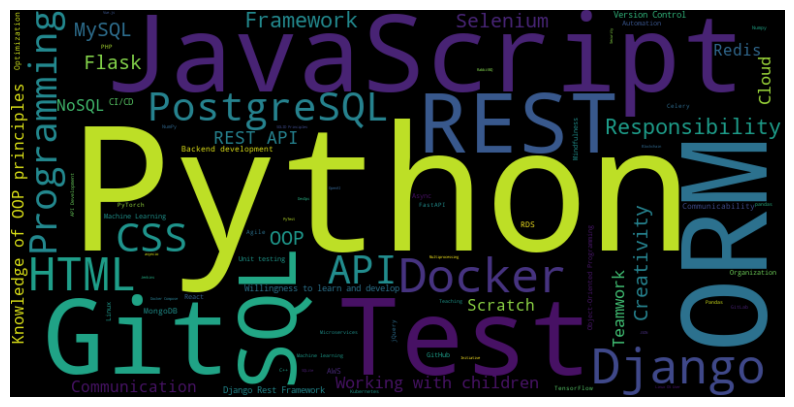

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


wordcloud = WordCloud(
    width=800, height=400, colormap="viridis"
).generate_from_frequencies(skills_counter)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

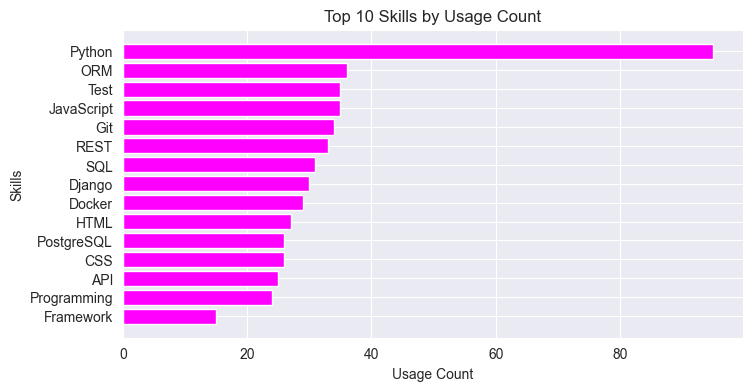

In [11]:
top_skills = skills_df.head(15)

plt.figure(figsize=(8, 4))
plt.barh(top_skills["skill"], top_skills["usage_count"], color="magenta")
plt.xlabel("Usage Count")
plt.ylabel("Skills")
plt.title("Top 10 Skills by Usage Count")
plt.gca().invert_yaxis()
plt.show()

In [12]:
def map_title(title):
    title_lower = title.lower()
    
    if "python developer" in title_lower:
        title_lower = "python developer"
    elif "teacher" in title_lower:
        title_lower = "teacher of programming"
    elif "full stack" in title_lower or "full-stack" in title_lower:
        title_lower = "full-stack developer"
    
    return title_lower

df["title_standardized"] = df["title"].apply(map_title)
df.head()

,title,skills,salary,company,job_description,link,keywords,all_skills,title_standardized
0,Python Developer,"Java,PHP,MySQL,Git,GitHub,GitLab,JavaScript,Py...",NaN,PNN Soft,requirements: bachelor’s or master’s degree i...,https://www.work.ua/en/jobs/5536195/,"[API, Cloud, Docker, Git, MongoDB, MySQL, Obje...","[Java, PHP, MySQL, Git, GitHub, GitLab, JavaSc...",python developer
1,Python developer,"Linux OS user, SQL, Git, Python, Docker, Teamw...",NaN,Canyon Development,canyon development is inviting a python develo...,https://www.work.ua/en/jobs/5706480/,"[Docker, Git, Linux, Multithreading, NoSQL, Op...","[Linux OS user, SQL, Git, Python, Docker, Team...",python developer
2,"Python Developer (Scraping), Data engineer","HTML,GitHub,JavaScript,Python,JSON,Knowledge o...",16400–22000 UAH,InterBox,requirements: knowledge of python; oop; bas...,https://www.work.ua/en/jobs/5733831/,"[API, Async, Automation, BeautifulSoup, Git, H...","[HTML, GitHub, JavaScript, Python, JSON, Knowl...",python developer
3,"Teacher of Scratch, Python at the All-Ukrainia...","Python, Scratch, Working with children",4000–9000 UAH,"Logika, an international programming school fo...",who is logika: we implement the latest it tech...,https://www.work.ua/en/jobs/5733816/,"[CSS, HTML, JavaScript, ORM, Python, Test]","[Python, Scratch, Working with children, CSS, ...",teacher of programming
4,Teacher at the All-Ukrainian programming schoo...,"CSS,JavaScript,HTML,Python,Communication,Progr...",10000 UAH,"Logika, an international programming school fo...",where we are looking for candidates: in the ci...,https://www.work.ua/en/jobs/5732860/,"[CSS, HTML, JavaScript, ORM, Python, Test]","[CSS, JavaScript, HTML, Python, Communication,...",teacher of programming


In [13]:
title_counter = Counter(df["title_standardized"])

title_df = pd.DataFrame.from_dict(title_counter, orient="index", columns=["usage_count"]).reset_index()
title_df = title_df.rename(columns={"index": "title"})
title_df = title_df.sort_values(by="usage_count", ascending=False).reset_index(drop=True)

title_df.head()

,title,usage_count
0,python developer,17
1,teacher of programming,17
2,python programmer,4
3,full-stack developer,3
4,"senior software engineer (node, python, llm)",1


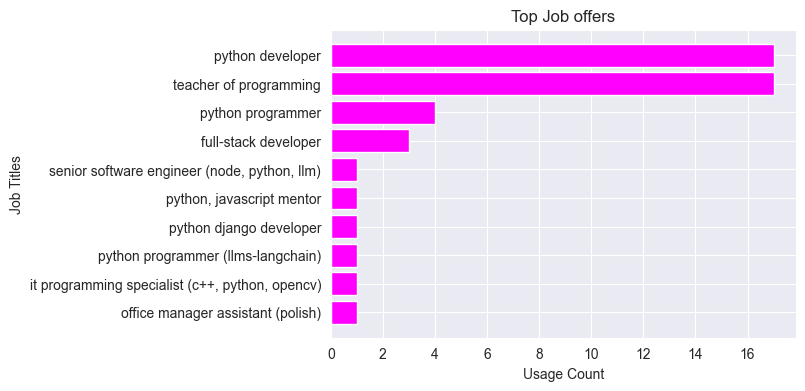

In [14]:
top_offers = title_df.head(10)

plt.figure(figsize=(6, 4))
plt.barh(top_offers["title"], top_offers["usage_count"], color="magenta")
plt.xlabel("Usage Count")
plt.ylabel("Job Titles")
plt.title("Top Job offers")
plt.gca().invert_yaxis()
plt.show()

In [15]:
import seaborn as sns


top_skills = top_skills["skill"][:10].to_list()
top_titles = top_offers["title"][:10].to_list()

print(top_skills)
print(top_titles)



['Python', 'ORM', 'Test', 'JavaScript', 'Git', 'REST', 'SQL', 'Django', 'Docker', 'HTML']
['python developer', 'teacher of programming', 'python programmer', 'full-stack developer', 'senior software engineer (node, python, llm)', 'python, javascript mentor', 'python django developer', 'python programmer (llms-langchain)', 'it programming specialist (c++, python, opencv)', 'office manager assistant (polish)']


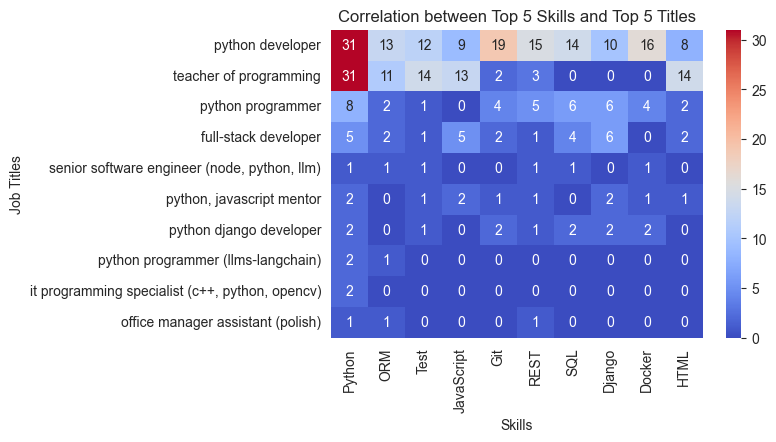

In [16]:
top_titles = [title[:50] for title in top_titles]

correlation_matrix = pd.DataFrame(0, index=top_titles, columns=top_skills)

for index, row in df.iterrows():
    title = row["title_standardized"]
    skills = row["all_skills"]
    if title in top_titles:
        for skill in skills:
            if skill in top_skills:
                correlation_matrix.at[title, skill] += 1


plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt="d")
plt.title("Correlation between Top 5 Skills and Top 5 Titles")
plt.xlabel("Skills")
plt.ylabel("Job Titles")
plt.show()